# Extra 2 - **Arquitectura personalitzada**

En els exemples que hem estat fent fins ara, sempre hem utilitzat xarxes prefabricades (com resnet18, resent50, etc) per fer transfer learning. En aquest exemple, intentarem crear la nostra pròpia topologia de xarxa neuronal fent servir Pytorch i l'entrenarem *"des de zero"*. Els resultats que obtindrem no seràn tant bons, però tot i això és un exemple interessant.

### **1. Carregar Imatges**

En aquesta secció crearem l'objecte ``ImageDataLoader``, que ens ajudarà a carregar les imatges a la xarxa neuronal. Perquè les següents cel·les de codi funcionin, el dataset d'imatges que se'ns ha proporcionat per fer la pràctica ha d'estar descomprimit sota el nom ``dataset_CIFAR10`` al mateix directori on s'estigui executant aquest Notebook i l'estructura dels seus directoris no ha d'haver patit cap modificació.

Comencem important les llibreries que necessitarem durant aquest Notebook:

In [53]:
import fastai
import torch
from fastai.vision.all import *
from fastai.callback.fp16 import *
fastbook.setup_book()


In [19]:
dls = ImageDataLoaders.from_folder(
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'), # Usem CUDA si està disponible
    path = 'dataset_CIFAR10', # Path al dataset
    train = 'train', # Sub-directori amb les imatges d'entrenament
    valid = 'validation', # Sub-directori amb les imatges de validació
    seed = 42, # Llavor aleatòria
    bs = 1024) # Mida del batch

<br>

Mostrem un petit batch d'imatges, per comprovar que s'hagin carregat correctament:

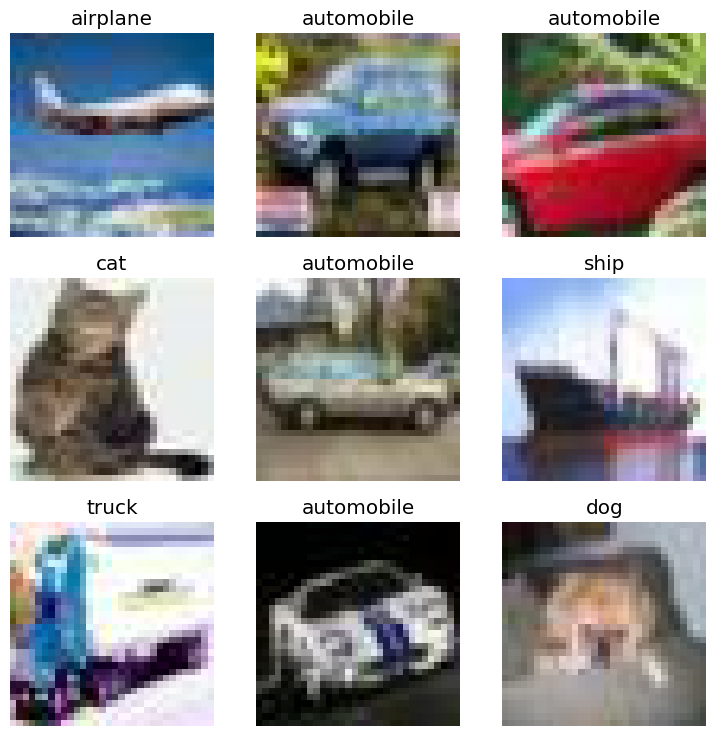

In [20]:
dls.show_batch()

Amb això, ja estem preparats per començar a fer la nostra xarxa neuronal.

### **2. Crear la xarxa neuronal**

#### **2.1. Les fòrmules *màgiques***

En els exemples anteriors que hem fet en aquesta pràctica hem utilitzat xarxes prefabricades per tal de construir el clasificador, i per tant no ens hem hagut de preocupar gens per la mida de les capes. No obstant, si volem crear la nostra xarxa "des de zero" haurem de ser molt curosos a l'hora de definir les capes per tal que la mida de la imatge que doni com a output la última capa convolucional encaixi amb el nombre d'inputs que accepta la primera capa densa, i també perquè la dimensió de les imatges no es redueixi excessivament a mesura que es va propagant a través de les capes convolucionals.

La següent fòrmula ens permet saber quina serà la altura/amplada d'una imatge després de passar-la per una capa convolucional d'unes característiques determinades:

$S_{out} = \lfloor \frac{S_{in} - K + 2 \cdot P}{Str} +1 \rfloor $

a on:

   * $S_{in} $ i $ S_{out}$ són l'amplada (o la altura) de la image d'input i d'output respectivament.
   * $K$ és la mida del kernel.
   * $P$ és el valor del *padding*.
   * $Str$ és el valor d'stride.
   * $\lfloor \, \, \rfloor$ és l'operador *floor*.

I en el cas d'una capa de ``MaxPooling``, la mida resultant serà:

$S_{out} = \lfloor \frac{S_{in}-K}{Str}  +1 \rfloor$

Al següent sub-apartat, farem servir aquestes fòrmules per comprovar que la xarxa que hem definit estigui ben construida i les dimensions de cada capa encaixin correctament.

#### **2.2. Definir la xarxa**

En aquesta sub-secció definrem dues xarxes diferents, les estudiarem i comprarem els seus resultats.

##### Xarxa 1

Comencem per una xarxa senzilla i poc profunda, que sigui fàcil d'analitzar:

In [38]:
class HomemadeCNN_mk1(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Capes convolucionals.
        # La primera rep com a input una imatge de 32x32x3 (de fet, un batch d'imatges)
        self.conv1 = nn.Conv2d(3, 8, 3) #30x30x8
        self.pool1 = nn.MaxPool2d(2, 2) #15x15x8
        self.conv2 = nn.Conv2d(8, 16, 3) # 13x13x16
        self.pool2 = nn.MaxPool2d(2, 2) #6x6x16
        
        # Capes fully-connected
        self.fc1 = nn.Linear(6 * 6 * 16, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        
        # Propagació cap endavant de les capes convolucionals:
        x = self.pool1(F.relu(self.conv1(x))) # Convolució + ReLu + MaxPool
        x = self.pool2(F.relu(self.conv2(x))) # Convolució + ReLu + MaxPool
        
        # Encadenem tots els píxels de cada imatge en forma de vector:
        x = torch.flatten(x, 1) 
        
        # Propagació cap endavant a les capes fully connected:
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

Anem a veure què fa exactament aquesta classe que acabem de definir, i com canvia la dimensió de la imatge original a mesura que avança a través de les capes. A l'hora de crear una xarxa neuronal amb Pytorch, hem de crear una classe que heredi de ``nn.Module``. Després, hem de definir dos mètodes propis:


*   ``__init__()`` - El constructor. Aquí definim el nombre de capes que tindrà la xarxa neuronal, i els seus tipus.
*   ``forward()`` - Funció de propagació cap endavant. Rep un input ``x``, i hem d'especificar com es va transformant aquest input, fent servir les capes que hem definit al constructor.


Aquesta xarxa neuronal rebrà com a input una imatge (de fet, un batch d'imatges) de 32x32 píxels, en tres canals . La primera capa, que hem batejat com a ``conv1``, és una capa convolucional (tipus ``Conv2d``) que aplica 8 filtres de 3x3 sobre l'input. Com que no hem dit el contrari, l'stride és 1 i el padding és 0. Aplicant la primera de les fòrmules, ens surt:

$S_{out} = \frac{32 - 3 - 2 \cdot 0}{1} +1 = 30$

Per tant, aquesta primera capa dóna com a output una imatge de 8 canals i 30x30 píxels. Després, s'aplica un maxpooling que redueix el tamany a 15x15 (preservant el núm. de canals). La segona capa convolucional produirà com a output una imatge de 16 canals i 13x13 píxels, a la que s'aplicarà després un altre max pooling i es convertirà en una imatge de 6x6 píxels i 16 canals. <br>

Així doncs, la primera capa *fully connected*, que és de tipus ``nn.Linear``, haurà de rebre $6 \cdot 6 \cdot 16$ paràmetres com a input. Després, és només qüestió d'assegurar-nos que la mida de l'output de cada capa ``nn.Linear`` coincideixi amb l'input de la següent.

<br>

Creem ara el ``Learner`` i entrenem durant 20 èpoques:

In [40]:
learn = Learner(dls, HomemadeCNN_mk1(), loss_func = torch.nn.CrossEntropyLoss(), metrics=[accuracy, error_rate], opt_func = Adam, lr = 1e-3 )
learn.fit(20)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.171620,1.966012,0.264200,0.735800,00:03
1,1.940566,1.779821,0.336300,0.663700,00:03
2,1.819666,1.703033,0.371900,0.628100,00:03
3,1.730982,1.640368,0.395200,0.604800,00:04
4,1.665851,1.592943,0.420500,0.579500,00:03
5,1.609505,1.553234,0.433300,0.566700,00:04
6,1.568132,1.532448,0.444500,0.555500,00:04
7,1.532891,1.495836,0.457400,0.542600,00:04
8,1.505720,1.476836,0.464800,0.535200,00:03
9,1.474073,1.452487,0.476100,0.523900,00:04


Hem obtingut un 54% de precisió. Per començar, tampoc està tant malament, tenint en compte que hi ha 10 classes a predir i un classificador aleatori tindria una precisió propera al 20%. No obstant, hi ha alguna manera de millorar els resultats?

##### Xarxa 2

Anem ara a crear una xarxa més profunda i amb més neurones per intentar superar la precisió que tenim de moment.

In [41]:
class HomemadeCNN_mk2(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Capes convolucionals, bloc 1
        # Recordem que la mida de cada imatge d'input és 32x32x3
        self.conv1 = nn.Conv2d(3, 32, 3) # 30x30x32
        self.conv2 = nn.Conv2d(32,64,3) # 28x28x64
        self.pool1 = nn.MaxPool2d(2, 2) # 14x14x64
        
        # Capes convolucionals, bloc 2
        self.conv3 = nn.Conv2d(64,128,3) #12x12x128
        self.conv4 = nn.Conv2d(128,256,3) #10x10x256
        self.pool2 = nn.MaxPool2d(2,2) #5x5x256
    
        
        # Capes fully-connected:
        self.fc1 = nn.Linear(256 * 5 * 5, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        
        # Propagació cap endavant del 1r bloc convolucional:
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        
        # Propagació cap endavant del 2n bloc convolucional:
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        
        # Encadenem tots els píxels de cada imatge en forma de vector:
        x = torch.flatten(x, 1)
        
        # Propagació cap endavant a les capes fully connected:
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

<br>

Fem un entrenament durant 20 èpoques:

In [57]:
learn = Learner(dls, HomemadeCNN_mk2(), loss_func = CrossEntropyLossFlat(), metrics=[accuracy, error_rate], opt_func = Adam, lr = 1e-3 )
learn.fit(20)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.005632,1.754080,0.355700,0.644300,00:04
1,1.738135,1.525360,0.435600,0.564400,00:04
2,1.566668,1.423887,0.485000,0.515000,00:04
3,1.412061,1.269995,0.549200,0.450800,00:04
4,1.290322,1.177125,0.586600,0.413400,00:04
5,1.172978,1.094033,0.614700,0.385300,00:04
6,1.074110,1.042001,0.633800,0.366200,00:04
7,0.977169,0.964263,0.666100,0.333900,00:04
8,0.888305,0.937762,0.678000,0.322000,00:04
9,0.810922,0.900188,0.686100,0.313900,00:04


Observem que amb aquesta segona capa més profunda i amb més filtres, hem aconseguit una precisió del ~71%, que no està malament per tractar-se d'un classificador entrenat amb -relativament- pocs exemples. Mostrem també la matriu de confusió:

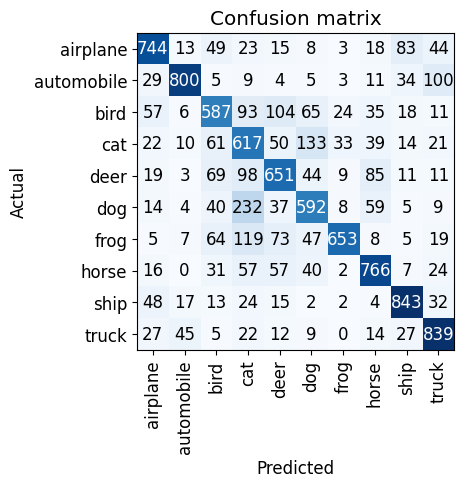

In [60]:
interpretador = ClassificationInterpretation.from_learner(learn)
interpretador.plot_confusion_matrix()

Observem que, en general, les classes estàn classificades amb bastant encert. El model, però, té una mica més de dificultat diferenciant gats i gossos (la qual cosa és raonable) i granotes i gats (la qual cosa ja és menys raonable). També té alguna confusió a l'hora de diferenciar algun cotxe i camió.

Per últim, mostrem el TOP 10 d'imatges a on el classificador s'ha equivocat més (és a dir, tenen un valor de ``loss`` més gran):

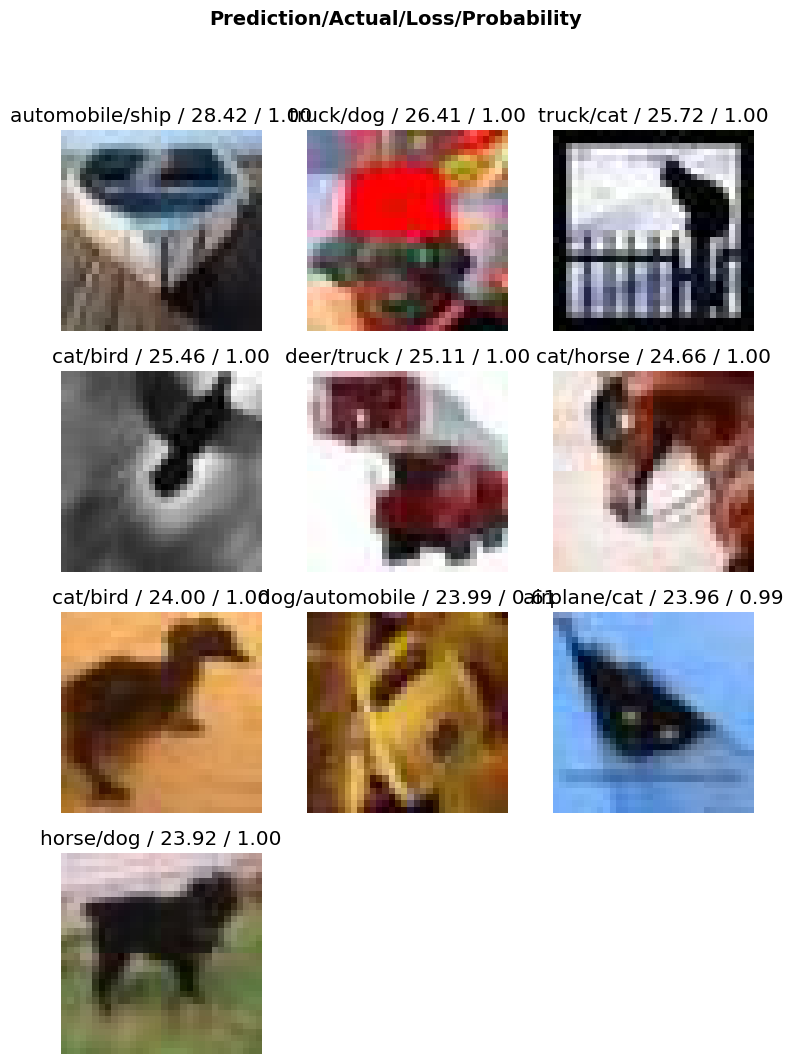

In [63]:
interpretador.plot_top_losses(10, nrows=4)